#IDENTIFICACIÓN Y CARACTERIZACIÓN DE MATERIALES 2D USANDO TÉCNICAS DE PROCESAMIENTO DE IMAGENES E INTELIGENCIA ARTIFICIAL


# **Estructuramiento del modelo**                  

# Indice
1. Objetivo
2. Librerías
3. Importación de datos
4. Lectura de imagenes
5. Descripción de la base de datos         
  5.1. Tamaño de la base de datos y dimensiones
6. Visualización de datos   
   6.1. Distribución de clases a nivel de etiquetas   
   6.2. Distribución de clases a nivel de pixeles   
   6.3. Mapa de calor
7. Análisis de caracteristicas   
  7.1. Histograma de intensidad en escala de grises    
  7.2. Histograma del canal RGB   
  7.3. Diagrama de cajas RGB por clases   
  7.4. Ejemplo de imagen filtrada por canales   
  7.5. Modelo HSV   
  7.6. Diagrama de cajas HSV por clases   

#1. Objetivo

Los materiales bidimensionales (2D) son una clase de sólidos cristalinos que presentan una amplia gama de propiedades electrónicas de interés para aplicaciones en electrónica, almacenamiento de energía, catálisis e incluso medicina. Sin embargo, la obtención de estos no es una labor sencilla, pues requiere de un experto humano que seleccione de manera manual y usando un microscopio, las regiones de interés correspondientes a los materiales de interés. Debido a lo anterior, han surgido diversos intentos de automatizar el proceso de segmentación de imágenes para la identificación automática de los materiales 2D para reducir el tiempo requerido en la obtención de estos. El presente trabajo propone la construcción de un modelo basado en técnicas de procesamiento de imágenes y/o inteligencia artificial para la automatización del proceso de identificación de regiones de interés sobre imágenes obtenidas en el Laboratorio de Fotónica de la Universidad de Mackenzie, en Brasil.


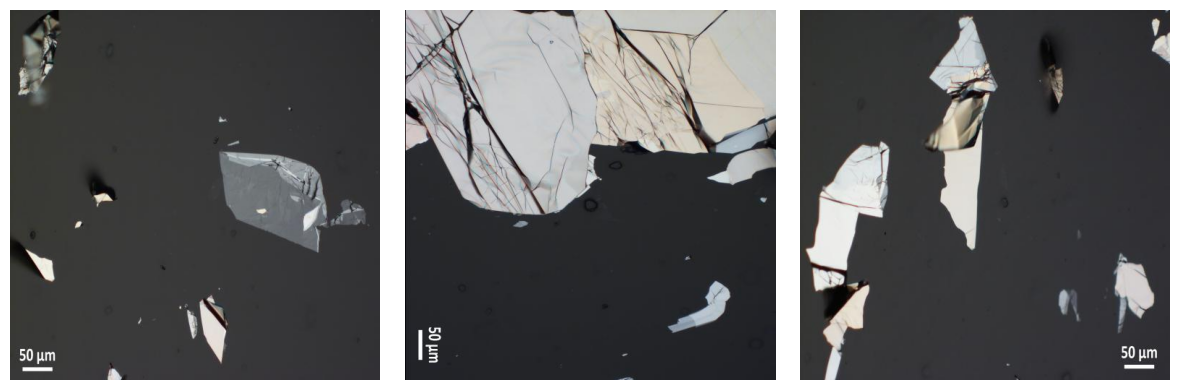




#2. Importación de librerías
En esta sección, se importan las librerías necesarias para construir y entrenar la red neuronal utilizando TensorFlow. Estas librerías permiten definir el modelo, configurar sus capas y entrenarlo de manera eficiente. Además, se incluyen módulos especializados para cargar y preprocesar las imágenes, asegurando que estén en el formato adecuado antes de ser enviadas al modelo.

In [ ]:
!pip install roboflow

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
from roboflow import Roboflow
import sys
from time import time
from progressbar import progressbar as pbar
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.utils import class_weight

from keras.utils import normalize
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras.metrics import F1Score # No funciona, preguntar

#3. Importación de imágenes
Se hace la exportación de imagenes haciendo uso de la API de Roboflow, lo cuál nos entrega nuestro dataset ya etiquetado con su respectiva máscara.

In [ ]:
rf = Roboflow(api_key="YJeW9pVCy9nQ7BwHkRIO")
project = rf.workspace("2d-materials-segmentation").project("2d-materials-segmentation")
version = project.version(4)
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 2D-Materials-segmentation-4 in png-mask-semantic:: 100%|██████████| 88/88 [00:00<00:00, 4470.94it/s]


## 3.1. Ejemplo de imagen y mascara
En esta sección, se presenta un ejemplo visual que ilustra cómo se ve una imagen junto con su respectiva máscara. La imagen representa los datos de entrada al modelo, mientras que la máscara corresponde a la segmentación objetivo, que identifica las regiones de interés (por ejemplo, clases como bulk, few layer y background). Este ejemplo ayuda a comprender la relación entre las imágenes originales y las etiquetas que el modelo utilizará durante el entrenamiento.


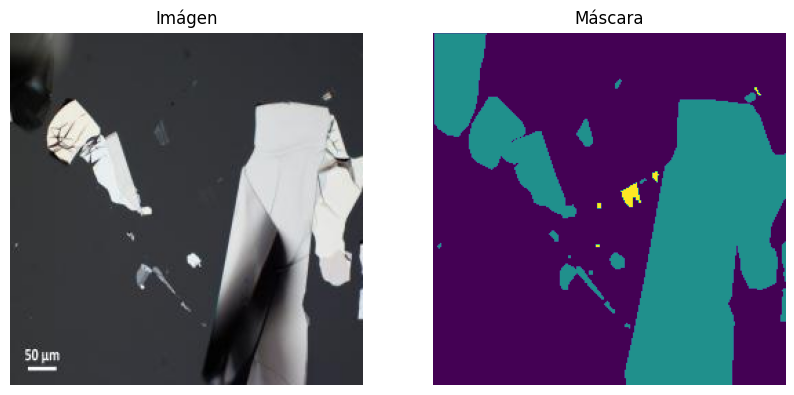

In [ ]:
img_path = "/content/2D-Materials-segmentation-4/test/11_Grafeno-em-PDMS_Maio_070524_Amostra-3_Floco-1_20X_png_jpg.rf.7e2525ad17dd5a1ddcd6aa6e0156adf0.jpg"
mask_path = "/content/2D-Materials-segmentation-4/test/11_Grafeno-em-PDMS_Maio_070524_Amostra-3_Floco-1_20X_png_jpg.rf.7e2525ad17dd5a1ddcd6aa6e0156adf0_mask.png"

img_test = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

mask_test = cv2.imread(mask_path)
mask_rgb = cv2.cvtColor(mask_test, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Imágen')

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb[:, :, 0])
plt.axis('off')
plt.title('Máscara')

plt.show()

In [ ]:
np.unique(mask_rgb[:,:,0]) # Las tres clases.

array([0, 1, 2], dtype=uint8)

#4. Carga de imagenes
En esta sección, se realiza la carga de las imágenes desde la carpeta de origen. Las imágenes se preprocesan y transforman a un formato compatible con el modelo, asegurando que tengan las dimensiones, el tipo de dato y el rango de valores correctos. Este paso es esencial para preparar los datos de entrada de manera eficiente y garantizar que sean interpretables por la red neuronal durante el entrenamiento y la validación.

In [ ]:
def plot_img(img, cmap = None):
  """
  Función para visualizar una imagen
  """

  plt.figure(figsize=(5, 5))
  plt.imshow(img, cmap = cmap)
  plt.axis('off')
  plt.show()

In [ ]:
def get_img_dir_arr_sorted(base_path):
  """
  Función para obtener las rutas de las imagenes y máscaras
  de una carpeta indicada y retornar un array con las rutas ordenadas
  """

  img_dir_list = os.listdir(base_path)
  if '_classes.csv' in img_dir_list:
    img_dir_list.remove('_classes.csv')

  img_dir_list.sort()
  img_dir_list_sorted_mapped = list(map(lambda x: os.path.join(base_path, x),
                             img_dir_list))

  # Observe que la longitud de la lista debe ser par
  img_dir_arr = np.array(img_dir_list_sorted_mapped).reshape(-1,2)
  return img_dir_arr

In [ ]:
def get_imgs_from_dir_arr(dir_arr):
    """
    Función para obtener las imágenes de una lista de rutas de imágenes y máscaras y
    devolver dos arrays de imágenes y máscaras
    """
    img_list = []  # Lista de imágenes
    mask_list = []  # Lista de máscaras

    # Carga de imágenes y máscaras con aumentos
    for item in dir_arr:
        img_path = os.path.join(item[0])
        mask_path = os.path.join(item[1])

        img = cv2.imread(img_path, 0)  # Escala de grises
        mask = cv2.imread(mask_path, 0)  # Escala de grises

        images = [img]
        masks = [mask]

        img_list.extend(images)
        mask_list.extend(masks)

    return np.array(img_list), np.array(mask_list)

## 4.1. Se cargan las imagenes y máscaras de entrenamiento, test y validación
En esta sección, se utilizan las funciones de carga definidas previamente para importar y preprocesar las imágenes junto con sus máscaras correspondientes. Los datos se dividen en conjuntos de entrenamiento, prueba y validación, asegurando una distribución adecuada para evaluar el desempeño del modelo. Las imágenes y máscaras procesadas se almacenan en variables específicas que se utilizarán durante el entrenamiento y la evaluación del modelo.

In [ ]:
# Obtener imágenes de las carpetas suministradas por RoboFlow API
train_base_path = "/content/2D-Materials-segmentation-4/train"
test_base_path = "/content/2D-Materials-segmentation-4/test"
val_base_path = "/content/2D-Materials-segmentation-4/valid"

train_dir_arr = get_img_dir_arr_sorted(train_base_path)
test_dir_arr = get_img_dir_arr_sorted(test_base_path)
val_dir_arr = get_img_dir_arr_sorted(val_base_path)

train_imgs, train_masks = get_imgs_from_dir_arr(train_dir_arr)
test_imgs, test_masks = get_imgs_from_dir_arr(test_dir_arr)
val_imgs, val_masks = get_imgs_from_dir_arr(val_dir_arr)



In [ ]:
# Probamos que los array de imágenes sí tengan las mismas dimensiones
assert train_imgs.shape == train_masks.shape
assert test_imgs.shape == test_masks.shape
assert val_imgs.shape == val_masks.shape

In [ ]:
train_imgs.shape, train_masks.shape

((32, 256, 256), (32, 256, 256))

## 4.2. Normalización de las imágenes
En este paso, las imágenes cargadas se normalizan para que sus valores de píxeles estén en un rango uniforme, generalmente entre 0 y 1. Este proceso mejora la estabilidad del entrenamiento al evitar grandes variaciones en los valores de entrada, lo que facilita que el modelo converja más rápido y de manera efectiva. La normalización es un paso clave para optimizar el rendimiento de la red neuronal.

In [ ]:
# Añadimos una dimensión y normalizamos las imagenes (no las máscaras)
train_imgs = np.expand_dims(train_imgs, axis=3)
train_imgs = normalize(train_imgs, axis=1)
train_masks = np.expand_dims(train_masks, axis=3)

test_imgs = np.expand_dims(test_imgs, axis=3)
test_imgs = normalize(test_imgs, axis=1)
test_masks = np.expand_dims(test_masks, axis=3)

val_imgs = np.expand_dims(val_imgs, axis=3)
val_imgs = normalize(val_imgs, axis=1)
val_masks = np.expand_dims(val_masks, axis=3)

##4.3. Codificación de las máscaras
En esta sección, las máscaras de segmentación se transforman a un formato codificado que el modelo pueda interpretar. Esto implica convertir los valores de las máscaras en categorías numéricas. Este paso es crucial para garantizar que las máscaras estén alineadas con la salida esperada del modelo y permitan un cálculo correcto de la función de pérdida durante el entrenamiento.

In [ ]:
#Cambio para color
N_CLASSES = len(np.unique(train_masks))
IMG_HEIGHT = train_masks.shape[1]
IMG_WIDTH  = train_masks.shape[2]
IMG_CHANNELS = train_masks.shape[3]

train_masks_cat = to_categorical(train_masks, num_classes=N_CLASSES)
test_masks_cat = to_categorical(test_masks, num_classes=N_CLASSES)
val_masks_cat = to_categorical(val_masks, num_classes=N_CLASSES)

# 5. Arquitectura del Modelo
En esta sección se define la estructura de la red neuronal utilizada para la segmentación semántica. Se implementarán y probarán arquitecturas con profundidades máximas de 64, 128, 256 y 512 filtros en las capas convolucionales. Para cada configuración, se entrenará el modelo y se monitorearán las métricas clave como precisión, recall y exactitud en distintas épocas (10, 25, 50 y 100). El objetivo es comparar el desempeño de las diferentes arquitecturas y seleccionar la que ofrezca el mejor balance entre complejidad y precisión.

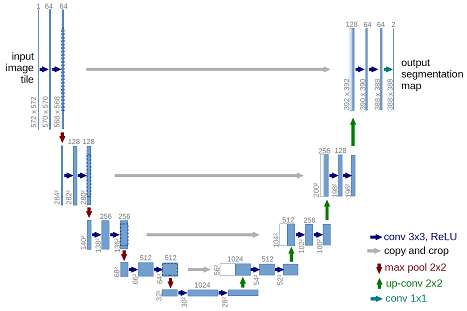



## 5.1. Funciones para automatizar el entrenamiento de los modelos
Se implementan funciones que automatizan el proceso de entrenamiento, incluyendo el cálculo de métricas como Mean Intersection over Union (Mean IoU), Recall, Accuracy y F1-Score, así como la compilación del modelo con el optimizador, la función de pérdida y las métricas a monitorear. Además, se registra el tiempo de entrenamiento en minutos y se monitorean las métricas en cortes específicos (10, 25, 50 y 100 épocas) para evaluar el desempeño y eficiencia de las arquitecturas probadas, facilitando comparaciones precisas y un flujo de trabajo reproducible.

In [ ]:
"""
Se crea una instancia de EarlyStopping para monitorizar la pérdida de validación
"""

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    mode='min',
    restore_best_weights=True)

In [ ]:
class TimeHistory(tf.keras.callbacks.Callback):
    """
    Callback para medir el tiempo de ejecución de cada época
    """
    def __init__(self, target_epochs):
        super().__init__()
        self.target_epochs = target_epochs
        self.epoch_times = {}

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time()

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.target_epochs:
            end_time = time()
            self.epoch_times[epoch + 1] = end_time - self.start_time

In [ ]:
def mean_iou(y_true, y_pred):
    """
    Función para calcular el coeficiente de IoU
    """
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0


In [ ]:
def train_model(batch_size=8, model=None, target_epochs=[10, 25, 50, 100]):
    """
    Función para entrenar el modelo y calcular métricas en épocas específicas
    """

    # Instanciar el callback para medir tiempo en épocas específicas
    time_callback = TimeHistory(target_epochs)

    # Diccionarios para almacenar métricas en las épocas específicas
    metrics_per_epoch = {
        "accuracy": {},
        "loss": {},
        "f1_score": {},
        "mean_iou": {},
        "precision": {},
        "recall": {},
        "time": {}
    }

    # Entrenamiento del modelo durante 200 épocas
    history = model.fit(
        train_imgs, train_masks_cat,
        batch_size=batch_size,
        verbose=1,
        epochs=100,
        validation_data=(test_imgs, test_masks_cat),
        shuffle=True,
        callbacks=[time_callback])

    # Predecir y calcular métricas solo en las épocas especificadas
    for epoch in target_epochs:
        y_pred = model.predict(test_imgs)
        y_pred = (y_pred > 0.5).astype(int)

        accuracy = history.history['val_accuracy'][epoch - 1]
        loss = history.history['val_loss'][epoch - 1]
        precision = precision_score(test_masks_cat.flatten(), y_pred.flatten(), average='weighted')
        recall = recall_score(test_masks_cat.flatten(), y_pred.flatten(), average='weighted')
        f1 = f1_score(test_masks_cat.flatten(), y_pred.flatten(), average='weighted')
        iou = mean_iou(test_masks_cat.flatten(), y_pred.flatten())
        time_epoch = time_callback.epoch_times.get(epoch, None)

        # Guardar métricas en el diccionario
        metrics_per_epoch["accuracy"][epoch] = accuracy
        metrics_per_epoch["loss"][epoch] = loss
        metrics_per_epoch["f1_score"][epoch] = f1
        metrics_per_epoch["mean_iou"][epoch] = iou
        metrics_per_epoch["precision"][epoch] = precision
        metrics_per_epoch["recall"][epoch] = recall
        metrics_per_epoch["time"][epoch] = time_epoch

    return metrics_per_epoch

## 5.2 Modelos UNet con 64 neuronas de profundidad máxima
El modelo UNet con 64 neuronas de profundidad máxima se construye con capas convolucionales (Conv2D) y capas de max pooling (MaxPooling2D) para la extracción de características, seguidas de capas de transposición convolucional (Conv2DTranspose) para la reconstrucción de la imagen. Se utiliza Dropout en varias capas para prevenir el sobreajuste y se emplea una función de activación ReLU en las capas ocultas y softmax en la capa de salida para la segmentación multiclase. Este modelo está diseñado para trabajar con imágenes de entrada de tamaño 256x256 y se configura para generar un número de clases especificado mediante el parámetro n_classes.

In [ ]:
def multi_unet_model64(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    """
    Función para crear el modelo UNet con 64 neuronas de profundidad
    """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### 5.2.1 Compilación del modelo64

En esta sección, se compila el modelo UNet con 64 neuronas de profundidad máxima utilizando el optimizador Adam y la función de pérdida categorical_crossentropy, adecuada para problemas de clasificación multiclase. Se especifican las métricas a monitorear durante el entrenamiento, que incluyen accuracy (precisión), Precision (precisión) y Recall (sensibilidad), para evaluar el desempeño del modelo en cada época. Finalmente, se imprime un resumen del modelo para visualizar la estructura y los parámetros del mismo.

In [ ]:
model64 = multi_unet_model64(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model64.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model64.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 128, 128, 32)   │          8,224 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 64)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 32)   │         18,464 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1   

 Total params: 116,787 (456.20 KB)

 Trainable params: 116,787 (456.20 KB)

 Non-trainable params: 0 (0.00 B)

### 5.2.2. Entrenamiento del modelo64
En esta sección, el modelo UNet con 64 neuronas de profundidad máxima se entrena utilizando los datos de entrenamiento y validación previamente cargados. El modelo se ajusta a las imágenes y máscaras de entrenamiento, con un número de épocas 100 y un tamaño de batch 8.

In [ ]:
metricas_64 = train_model(model=model64)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - Precision: 0.4667 - Recall: 4.0690e-06 - accuracy: 0.5588 - loss: 1.0817 - val_Precision: 0.3368 - val_Recall: 9.7656e-05 - val_accuracy: 0.7980 - val_loss: 1.0149
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - Precision: 0.5195 - Recall: 0.1375 - accuracy: 0.7713 - loss: 0.9644 - val_Precision: 0.7969 - val_Recall: 0.7722 - val_accuracy: 0.7980 - val_loss: 0.7819
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - Precision: 0.7789 - Recall: 0.7631 - accuracy: 0.7809 - loss: 0.8544 - val_Precision: 0.7970 - val_Recall: 0.7606 - val_accuracy: 0.7980 - val_loss: 0.7164
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - Precision: 0.7731 - Recall: 0.7247 - accuracy: 0.7759 - loss: 0.7174 - val_Precision: 0.7972 - val_Recall: 0.7854 - val_accuracy: 0.7979 - val_loss: 0.6316
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - Precision: 0.7665 - Recall: 0.7466 - accuracy: 0.7635 - loss: 0.6513 - val_Precision: 0.7971 - val_Recall: 0.790

In [ ]:
metricas_64

{'accuracy': {10: 0.7979675531387329,
  25: 0.8735992312431335,
  50: 0.9130035638809204,
  100: 0.937347412109375},
 'loss': {10: 0.5224843621253967,
  25: 0.4634437561035156,
  50: 0.3217683732509613,
  100: 0.23072710633277893},
 'f1_score': {10: 0.9582268310948031,
  25: 0.9582268310948031,
  50: 0.9582268310948031,
  100: 0.9582268310948031},
 'mean_iou': {10: 0.8820481149012568,
  25: 0.8820481149012568,
  50: 0.8820481149012568,
  100: 0.8820481149012568},
 'precision': {10: 0.958224153922158,
  25: 0.958224153922158,
  50: 0.958224153922158,
  100: 0.958224153922158},
 'recall': {10: 0.9582295735677083,
  25: 0.9582295735677083,
  50: 0.9582295735677083,
  100: 0.9582295735677083},
 'time': {10: 20.62338423728943,
  25: 21.51221513748169,
  50: 21.021501064300537,
  100: 20.008212089538574}}

##5.3 Modelos UNet con 128 neuronas máximo de profundidad
El modelo UNet con 128 neuronas de profundidad máxima se construye con una arquitectura similar a la de 64 neuronas, pero con una capa adicional de convolución de mayor profundidad (128 neuronas) en las etapas de contracción. Se aplican capas de convolución (Conv2D) con ReLU como función de activación y Dropout en varias capas para prevenir el sobreajuste. A lo largo de la red, se utiliza MaxPooling2D para reducir la dimensionalidad y Conv2DTranspose para la expansión y reconstrucción de las imágenes. La capa final es una convolución con un filtro de tamaño 1x1 y activación softmax para la segmentación multiclase. Este modelo está diseñado para trabajar con imágenes de entrada de tamaño 256x256 y es capaz de segmentar un número de clases determinado por el parámetro n_classes.

In [ ]:
def multi_unet_model128(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    """
    Función para crear el modelo UNet con 128 neuronas de profundidad
    """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Expansion path
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

### 5.3.1. Compilación del modelo128
En esta sección, el modelo UNet con 128 neuronas de profundidad máxima se compila utilizando el optimizador Adam y la función de pérdida categorical_crossentropy, adecuada para problemas de clasificación multiclase. Las métricas a monitorear durante el entrenamiento incluyen accuracy (precisión), Precision (precisión) y Recall (sensibilidad), para evaluar el desempeño del modelo en cada época. El resumen del modelo se imprime para verificar su estructura y los parámetros configurados, asegurando que las capas estén correctamente definidas para la segmentación de múltiples clases.

In [ ]:
model128 = multi_unet_model128(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model128.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'], )

model128.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 64)     │         32,832 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concaten

 Total params: 481,779 (1.84 MB)

 Trainable params: 481,779 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### 5.3.2. Entrenamiento del modelo128
En esta sección, el modelo UNet con 128 neuronas de profundidad máxima se entrena utilizando los datos de entrenamiento y validación previamente procesados. Durante el entrenamiento, se ajustan los parámetros del modelo a las imágenes y máscaras de entrenamiento, utilizando el número de épocas y el tamaño de batch previamente definidos.

In [ ]:
metricas_128 = train_model(model=model128)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 7s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.2127 - loss: 1.1066 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.8054 - val_loss: 1.0775
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - Precision: 0.2955 - Recall: 0.0054 - accuracy: 0.7465 - loss: 1.0404 - val_Precision: 0.6999 - val_Recall: 0.3526 - val_accuracy: 0.7975 - val_loss: 0.8089
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - Precision: 0.7781 - Recall: 0.7092 - accuracy: 0.7829 - loss: 0.7940 - val_Precision: 0.7515 - val_Recall: 0.5203 - val_accuracy: 0.7979 - val_loss: 0.7747
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - Precision: 0.7715 - Recall: 0.6842 - accuracy: 0.7827 - loss: 0.7101 - val_Precision: 0.7919 - val_Recall: 0.7243 - val_accuracy: 0.7980 - val_loss: 0.7100
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - Precision: 0.7920 - Recall: 0.7672 - accuracy: 0.7932 - loss: 0.6499 - val_Precision: 0.7970 - val_Recall

In [ ]:
metricas_128

{'accuracy': {10: 0.7979675531387329,
  25: 0.7979675531387329,
  50: 0.929431140422821,
  100: 0.9544342160224915},
 'loss': {10: 0.5452882051467896,
  25: 0.3882974684238434,
  50: 0.2004048079252243,
  100: 0.1595541536808014},
 'f1_score': {10: 0.9696145557600631,
  25: 0.9696145557600631,
  50: 0.9696145557600631,
  100: 0.9696145557600631},
 'mean_iou': {10: 0.912782938560244,
  25: 0.912782938560244,
  50: 0.912782938560244,
  100: 0.912782938560244},
 'precision': {10: 0.9696106682380934,
  25: 0.9696106682380934,
  50: 0.9696106682380934,
  100: 0.9696106682380934},
 'recall': {10: 0.9696187337239583,
  25: 0.9696187337239583,
  50: 0.9696187337239583,
  100: 0.9696187337239583},
 'time': {10: 41.28651785850525,
  25: 41.689284801483154,
  50: 22.324320077896118,
  100: 21.169958114624023}}

## 5.4. Modelos UNet con 256 neuronas máximo de profundidad
El modelo UNet con hasta 256 neuronas de profundidad está diseñado para la segmentación semántica de imágenes. Utiliza una arquitectura clásica con una ruta de contracción que extrae características mediante capas convolucionales y de pooling, seguida de una ruta expansiva que aumenta la resolución espacial utilizando transposición convolucional. Se emplean capas de Dropout para prevenir el sobreajuste y la activación ReLU en las capas ocultas. Finalmente, una capa de convolución 1x1 con activación softmax produce la segmentación multiclase. Este modelo está optimizado para trabajar con imágenes de entrada de 256x256 píxeles en escala de grises.

In [ ]:
def multi_unet_model256(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs


    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### 5.4.1. Compilación del modelo256
Se utiliza el optimizador Adam, que es eficiente para problemas de optimización no convexa como los de redes neuronales profundas. La función de pérdida es categorical_crossentropy, que es adecuada para tareas de clasificación multiclase. Además, se definen las métricas accuracy, Precision y Recall para evaluar el rendimiento del modelo durante el entrenamiento.


In [ ]:
model256 = multi_unet_model256(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model256.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'], )

model256.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 128)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 1,940,851 (7.40 MB)

 Trainable params: 1,940,851 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

### 5.4.2. Entrenamiento del modelo256
Se encarga de entrenar el modelo UNet con una estructura de 256 neuronas de profundidad máxima. En este paso, se utiliza el método fit para ajustar los parámetros del modelo a partir de los datos de entrenamiento, especificando la cantidad de épocas, el tamaño del batch y los datos de validación.

In [ ]:
metricas_256 = train_model(model=model256)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step - Precision: 0.0235 - Recall: 4.7684e-06 - accuracy: 0.4742 - loss: 1.0866 - val_Precision: 0.5500 - val_Recall: 0.0478 - val_accuracy: 0.7210 - val_loss: 0.9710
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - Precision: 0.6271 - Recall: 0.2371 - accuracy: 0.6936 - loss: 0.9582 - val_Precision: 0.7872 - val_Recall: 0.6878 - val_accuracy: 0.7958 - val_loss: 0.7314
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - Precision: 0.7421 - Recall: 0.6539 - accuracy: 0.7415 - loss: 0.7744 - val_Precision: 0.7946 - val_Recall: 0.7609 - val_accuracy: 0.7955 - val_loss: 0.6424
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - Precision: 0.7718 - Recall: 0.7497 - accuracy: 0.7697 - loss: 0.6691 - val_Precision: 0.7952 - val_Recall: 0.7612 - val_accuracy: 0.7980 - val_loss: 0.6609
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - Precision: 0.7841 - Recall: 0.7624 - accuracy: 0.7844 - loss: 0.6245 - val_Precision: 0.7969 - val_Recall: 0.7819 - v

In [ ]:
metricas_256

{'accuracy': {10: 0.7979675531387329,
  25: 0.9140625,
  50: 0.91253662109375,
  100: 0.9300537109375},
 'loss': {10: 0.5351932644844055,
  25: 0.24958038330078125,
  50: 0.3702264428138733,
  100: 0.40125030279159546},
 'f1_score': {10: 0.9533816101051755,
  25: 0.9533816101051755,
  50: 0.9533816101051755,
  100: 0.9533816101051755},
 'mean_iou': {10: 0.8692474946926291,
  25: 0.8692474946926291,
  50: 0.8692474946926291,
  100: 0.8692474946926291},
 'precision': {10: 0.9533769473831162,
  25: 0.9533769473831162,
  50: 0.9533769473831162,
  100: 0.9533769473831162},
 'recall': {10: 0.9533864339192708,
  25: 0.9533864339192708,
  50: 0.9533864339192708,
  100: 0.9533864339192708},
 'time': {10: 41.129796743392944,
  25: 43.154258728027344,
  50: 23.744267225265503,
  100: 41.79045867919922}}

## 5.5. Modelos UNet con 512 neuronas máximo de profundidad

El modelo UNet con hasta 512 neuronas de profundidad está diseñado para la segmentación semántica de imágenes. Utiliza una arquitectura clásica con una ruta de contracción que extrae características mediante capas convolucionales y de pooling, seguida de una ruta expansiva que aumenta la resolución espacial utilizando transposición convolucional. Se emplean capas de Dropout para prevenir el sobreajuste y la activación ReLU en las capas ocultas. Finalmente, una capa de convolución 1x1 con activación softmax produce la segmentación multiclase. Este modelo está optimizado para trabajar con imágenes de entrada de 256x256 píxeles en escala de grises.


In [ ]:
def multi_unet_model512(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contracción
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Expansión
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.1)(c10)
    c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1])
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.1)(c11)
    c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### 5.5.1 Compilación del modelo512
En esta sección, se compila el modelo UNet con 512 neuronas de profundidad máxima utilizando el optimizador Adam y la función de pérdida categorical_crossentropy, adecuada para problemas de clasificación multiclase. Se especifican las métricas a monitorear durante el entrenamiento, que incluyen accuracy (precisión), Precision (precisión) y Recall (sensibilidad), para evaluar el desempeño del modelo en cada época. Finalmente, se imprime un resumen del modelo para visualizar la estructura y los parámetros del mismo.

In [ ]:
model512 = multi_unet_model512(n_classes=N_CLASSES, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model512.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'], )

model512.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 16)   │            160 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 256, 256, 16)   │              0 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 16)   │          2,320 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 16)   │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 128, 128, 32)   │              0 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 32)     │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64, 64, 64)     │              0 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 64)     │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 32, 32, 128)    │              0 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 128)    │        147,584 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 7,775,347 (29.66 MB)

 Trainable params: 7,775,347 (29.66 MB)

 Non-trainable params: 0 (0.00 B)

### 5.5.2. Entrenamiento del modelo512
En esta sección, el modelo UNet con 512 neuronas de profundidad máxima se entrena utilizando los datos de entrenamiento y validación previamente cargados. El modelo se ajusta a las imágenes y máscaras de entrenamiento, con un número de épocas 100 y un tamaño de batch 8.

In [ ]:
metricas_512 = train_model(model=model512)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - Precision: 0.6169 - Recall: 0.2545 - accuracy: 0.6129 - loss: 2.5923 - val_Precision: 0.2273 - val_Recall: 1.5259e-05 - val_accuracy: 0.7948 - val_loss: 1.0208
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 7s/step - Precision: 0.1742 - Recall: 0.0012 - accuracy: 0.7270 - loss: 0.9942 - val_Precision: 0.1571 - val_Recall: 3.3569e-05 - val_accuracy: 0.7976 - val_loss: 1.0209
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 7s/step - Precision: 0.1008 - Recall: 7.2212e-04 - accuracy: 0.7552 - loss: 0.9987 - val_Precision: 0.0644 - val_Recall: 3.2654e-04 - val_accuracy: 0.7719 - val_loss: 0.9900
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - Precision: 0.4324 - Recall: 0.0169 - accuracy: 0.7276 - loss: 0.9610 - val_Precision: 0.5378 - val_Recall: 0.0237 - val_accuracy: 0.7415 - val_loss: 0.9424
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - Precision: 0.6565 - Recall: 0.1113 - accuracy: 0.6965 - loss: 0.8945 - val_Precision: 0.7022 - val_Recall

In [ ]:
metricas_512

# 6. Resultados de arquitecturas
En esta sección, se generará un gráfico comparativo que muestre el desempeño de las distintas arquitecturas de UNet con diferentes profundidades (64, 128, 256 y 512 neuronas).

El model128 se destaca como la mejor opción, logrando un equilibrio óptimo entre las métricas de desempeño (F1-Score, Accuracy y Mean IoU) y el tiempo de entrenamiento, mientras que el model64 ofrece resultados razonables con tiempos mucho menores, ideal si se busca eficiencia. Por otro lado, el model512, a pesar de ser el más profundo, muestra un desempeño inferior debido a un claro sobreajuste, ya que pierde capacidad de generalización y no mejora significativamente en métricas clave a pesar de su mayor complejidad y tiempo de entrenamiento

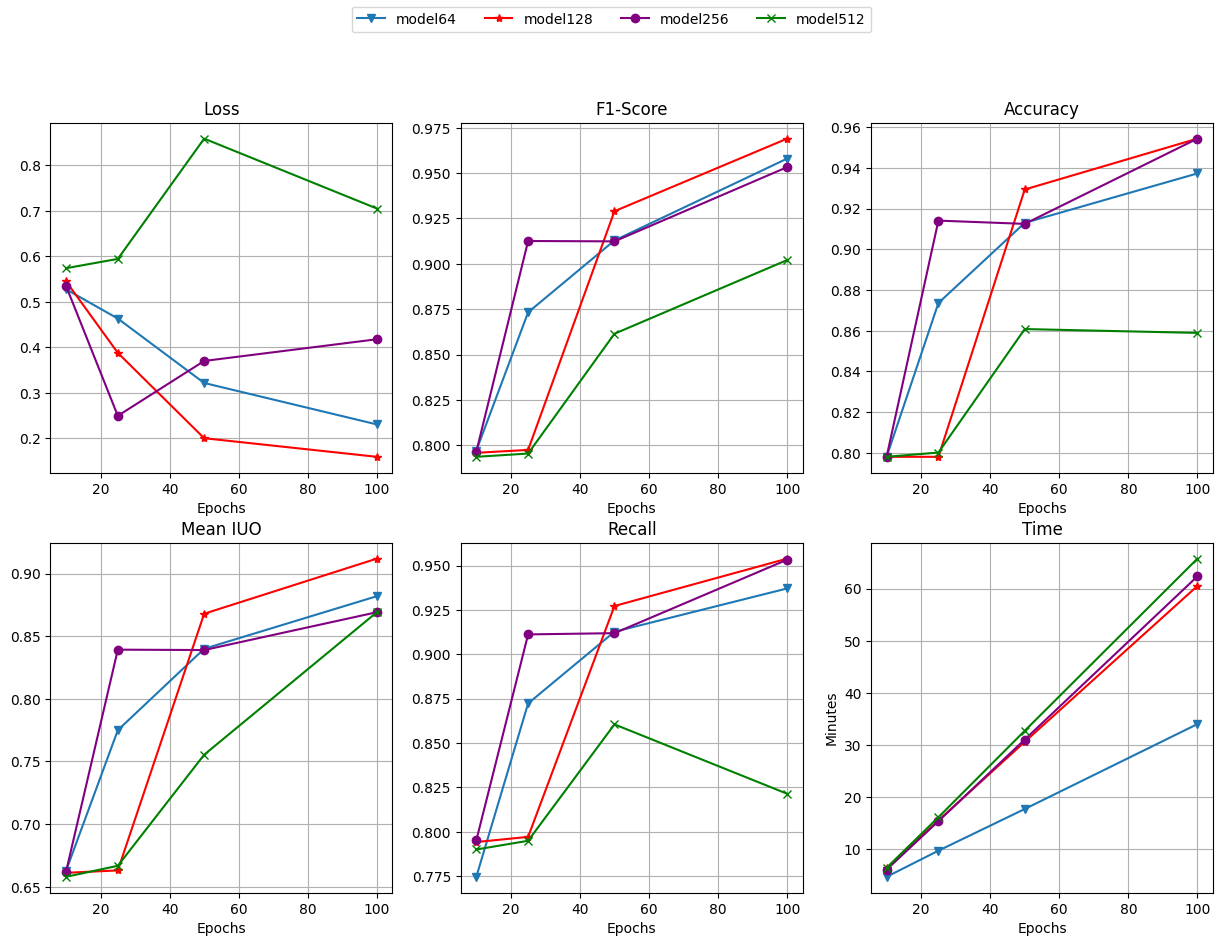

In [ ]:
# Datos el modelo 64 neuronas de profundidad
x1 = np.array([10, 25, 50, 100])
y1 =  np.array([0.5278, 0.4634, 0.3218, 0.2307])#Loss 64
y2 =  np.array([0.7971, 0.8733, 0.9129, 0.958])#F1 64
y3 = np.array([0.7980, 0.8736,0.913,0.9373]) # accuracy
y4 = np.array([0.6626, 0.775, 0.840, 0.882]) # Mean IUO
y5 = np.array([0.7746, 0.8723, 0.9127, 0.9371]) # Recall
y6 = np.array([4.7, 9.71, 17.71,34]) #Time

# Datos el modelo 128 neuronas de profundidad
y1_red = np.array([0.5453, 0.388, 0.2004, 0.1595]) #Loss 128
y2_red = np.array([0.7959, 0.7975, 0.929, 0.969]) #f1 128
y3_red = np.array([0.7980, 0.798, 0.9294, 0.9544]) #accuracy 128
y4_red = np.array([0.6611, 0.663, 0.868, 0.912]) # Mean IUO 128
y5_red = np.array([0.7942, 0.7971, 0.9272, 0.9539]) # Recall 128
y6_red = np.array([6.3, 15.51, 30.6, 60.5]) #Time

#Datos del modelo 256 neuronas de profundidad
y1_purp = np.array([0.5352, 0.2496, 0.3702, 0.4179]) #Loss 256
y2_purp = np.array([0.7965, 0.9126, 0.9124, 0.9533]) #f1 256
y3_purp = np.array([0.7980, 0.9141, 0.9125, 0.9544]) #accuracy 256
y4_purp = np.array([0.6619, 0.8393, 0.8390, 0.8692]) # Mean IUO 256
y5_purp = np.array([0.7951, 0.9112, 0.9119, 0.9533]) # Recall 256
y6_purp = np.array([6.08, 15.38, 31.03, 62.35]) #Time

#Datos del model 512 neuronas de profundidad
y1_green = np.array([0.5741, 0.5945, 0.8589, 0.7053]) #Loss 512
y2_green = np.array([0.7937, 0.7955, 0.8615, 0.9021]) #f1 512
y3_green = np.array([0.7980, 0.8001, 0.8608, 0.8589]) #accuracy 512
y4_green = np.array([0.6579, 0.6667, 0.7554, 0.8692]) # Mean IUO 512
y5_green = np.array([0.7900, 0.7949, 0.8605, 0.8214]) # Recall 512
y6_green = np.array([6.43, 16.13, 32.72, 65.74]) #Time

fig, axs = plt.subplots(2, 3, figsize=(15,10))

axs[0, 0].set_title('Loss')
axs[0, 0].plot(x1, y1, marker='v')
axs[0, 0].plot(x1, y1_red, marker='*', color='red')
axs[0, 0].plot(x1, y1_purp, marker='o', color='purple')
axs[0, 0].plot(x1, y1_green, marker='x', color='green')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].grid(True)

axs[0, 1].set_title('F1-Score')
axs[0, 1].plot(x1, y2, marker='v')
axs[0, 1].plot(x1, y2_red, marker='*', color='red')
axs[0, 1].plot(x1, y2_purp, marker='o', color='purple')
axs[0, 1].plot(x1, y2_green, marker='x', color='green')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].grid(True)

axs[0, 2].set_title('Accuracy')
axs[0, 2].plot(x1, y3, marker='v')
axs[0, 2].plot(x1, y3_red, marker='*', color='red')
axs[0, 2].plot(x1, y3_purp, marker='o', color='purple')
axs[0, 2].plot(x1, y3_green, marker='x', color='green')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].grid(True)

axs[1, 0].set_title('Mean IUO')
axs[1, 0].plot(x1, y4, marker='v')
axs[1, 0].plot(x1, y4_red, marker='*', color='red')
axs[1, 0].plot(x1, y4_purp, marker='o', color='purple')
axs[1, 0].plot(x1, y4_green, marker='x', color='green')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].grid(True)

axs[1, 1].set_title('Recall')
axs[1, 1].plot(x1, y5, marker='v')
axs[1, 1].plot(x1, y5_red, marker='*', color='red')
axs[1, 1].plot(x1, y5_purp, marker='o', color='purple')
axs[1, 1].plot(x1, y5_green, marker='x', color='green')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].grid(True)

axs[1, 2].set_title('Time')
axs[1, 2].plot(x1, y6, marker='v')
axs[1, 2].plot(x1, y6_red, marker='*', color='red')
axs[1, 2].plot(x1, y6_purp, marker='o', color='purple')
axs[1, 2].plot(x1, y6_green, marker='x', color='green')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Minutes')
axs[1, 2].grid(True)

fig.legend(['model64', 'model128', 'model256', 'model512'], loc='upper center', ncol=4)

# Mostrar el plot
plt.show()

# 7. Curva de aprendizaje

En esta sección, se aplicará una curva de aprendizaje al modelo UNet con 128 neuronas, que fue el que mostró los mejores resultados en las pruebas anteriores. El modelo se entrenará utilizando diferentes cantidades de imágenes: 6, 12, 18, 24 y 32, con el objetivo de observar cómo varía su rendimiento a medida que aumenta la cantidad de datos de entrenamiento. Para evaluar el rendimiento, se tomará como métrica principal el recall de cada clase (0, 1 y 2), ya que este valor refleja la capacidad del modelo para identificar correctamente los objetos de cada clase sin dejar ninguno sin clasificar

In [ ]:
def train_and_evaluate_with_varying_data(model_func, train_data_sizes, epochs=1):
    """
    Función para entrenar y evaluar el modelo con diferentes cantidades de datos de entrenamiento
    """
    results = {}
    for train_size in train_data_sizes:
        model = model_func()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        history = model.fit(
            train_imgs[:train_size], train_masks_cat[:train_size],
            batch_size=1,
            verbose=1,
            epochs=epochs,
            validation_data=(test_imgs, test_masks_cat),
            shuffle=True,
            )

        y_pred = model.predict(val_imgs)
        y_pred_classes = np.argmax(y_pred, axis=-1)
        y_true_classes = np.argmax(val_masks_cat, axis=-1)

        recall_class1 = recall_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[0], average='weighted')
        recall_class2 = recall_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[1], average='weighted')
        recall_class3 = recall_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[2], average='weighted')
        precision_class1 = precision_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[0], average='weighted')
        precision_class2 = precision_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[1], average='weighted')
        precision_class3 = precision_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[2], average='weighted')
        accuracy_class1 = accuracy_score(y_true_classes.flatten(), y_pred_classes.flatten(), normalize=True)
        accuracy_class2 = accuracy_score(y_true_classes.flatten(), y_pred_classes.flatten(),normalize=True)
        accuracy_class3 = accuracy_score(y_true_classes.flatten(), y_pred_classes.flatten(), normalize=True)
        f1_class1 = f1_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[0], average='weighted')
        f1_class2 = f1_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[1], average='weighted')
        f1_class3 = f1_score(y_true_classes.flatten(), y_pred_classes.flatten(), labels=[2], average='weighted')

        results[train_size] = [recall_class1, recall_class2, recall_class3, precision_class1, precision_class2, precision_class3, accuracy_class1, accuracy_class2, accuracy_class3, f1_class1, f1_class2, f1_class3]

    return results

In [ ]:
train_data_size = [6,12,18,24,32]
learning_by_data_size = train_and_evaluate_with_varying_data(multi_unet_model128, train_data_size ,40)

Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - Precision: 0.5138 - Recall: 0.0736 - accuracy: 0.2890 - loss: 1.0092 - val_Precision: 0.7867 - val_Recall: 0.7603 - val_accuracy: 0.7839 - val_loss: 0.6527
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - Precision: 0.8546 - Recall: 0.8492 - accuracy: 0.8536 - loss: 0.5283 - val_Precision: 0.7884 - val_Recall: 0.7028 - val_accuracy: 0.7980 - val_loss: 0.6949
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - Precision: 0.8360 - Recall: 0.7617 - accuracy: 0.8472 - loss: 0.6283 - val_Precision: 0.7965 - val_Recall: 0.7509 - val_accuracy: 0.7980 - val_loss: 0.6810
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 849ms/step - Precision: 0.8585 - Recall: 0.8471 - accuracy: 0.8594 - loss: 0.5796 - val_Precision: 0.7978 - val_Recall: 0.7967 - val_accuracy: 0.7980 - val_loss: 0.5951
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - Precision: 0.8223 - Recall: 0.8213 - accuracy: 0.8224 - loss: 0.5970 - val_Precision: 0.7977 - val_Recall: 0.7960 - val_accura

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - Precision: 0.7223 - Recall: 0.4284 - accuracy: 0.6763 - loss: 0.8986 - val_Precision: 0.7235 - val_Recall: 0.3908 - val_accuracy: 0.7974 - val_loss: 0.8004
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 939ms/step - Precision: 0.7908 - Recall: 0.6593 - accuracy: 0.8014 - loss: 0.7026 - val_Precision: 0.7981 - val_Recall: 0.7935 - val_accuracy: 0.7980 - val_loss: 0.6254
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 875ms/step - Precision: 0.8326 - Recall: 0.8157 - accuracy: 0.8305 - loss: 0.6221 - val_Precision: 0.8214 - val_Recall: 0.5638 - val_accuracy: 0.8155 - val_loss: 0.7160
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - Precision: 0.8170 - Recall: 0.7344 - accuracy: 0.8097 - loss: 0.6361 - val_Precision: 0.7979 - val_Recall: 0.7962 - val_accuracy: 0.7980 - val_loss: 0.5669
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 777ms/step - Precision: 0.7484 - Recall: 0.7429 - accuracy: 0.7485 - loss: 0.7131 - val_Precision: 0.7981 - val_Recall: 

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 888ms/step - Precision: 0.7262 - Recall: 0.0760 - accuracy: 0.5229 - loss: 1.0474 - val_Precision: 0.7881 - val_Recall: 0.6821 - val_accuracy: 0.7980 - val_loss: 0.8351
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 889ms/step - Precision: 0.8555 - Recall: 0.7695 - accuracy: 0.8653 - loss: 0.7296 - val_Precision: 0.7974 - val_Recall: 0.7942 - val_accuracy: 0.7979 - val_loss: 0.6090
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 880ms/step - Precision: 0.7824 - Recall: 0.7702 - accuracy: 0.7799 - loss: 0.6557 - val_Precision: 0.7976 - val_Recall: 0.7962 - val_accuracy: 0.7980 - val_loss: 0.5771
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 858ms/step - Precision: 0.7625 - Recall: 0.7586 - accuracy: 0.7615 - loss: 0.6516 - val_Precision: 0.7980 - val_Recall: 0.7980 - val_accuracy: 0.7980 - val_loss: 0.5654
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 895ms/step - Precision: 0.8272 - Recall: 0.8272 - accuracy: 0.8272 - loss: 0.5243 - val_Precision: 0.7984 - val_Re

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 932ms/step - Precision: 0.6360 - Recall: 0.1993 - accuracy: 0.5920 - loss: 1.0512 - val_Precision: 0.7682 - val_Recall: 0.5868 - val_accuracy: 0.7978 - val_loss: 0.7467
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 899ms/step - Precision: 0.8251 - Recall: 0.7904 - accuracy: 0.8240 - loss: 0.6403 - val_Precision: 0.7979 - val_Recall: 0.7936 - val_accuracy: 0.7976 - val_loss: 0.5667
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 902ms/step - Precision: 0.8190 - Recall: 0.8148 - accuracy: 0.8184 - loss: 0.5421 - val_Precision: 0.7980 - val_Recall: 0.7963 - val_accuracy: 0.7980 - val_loss: 0.5186
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - Precision: 0.7903 - Recall: 0.7885 - accuracy: 0.7902 - loss: 0.5208 - val_Precision: 0.7982 - val_Recall: 0.7980 - val_accuracy: 0.7980 - val_loss: 0.4979
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 824ms/step - Precision: 0.8199 - Recall: 0.8169 - accuracy: 0.8177 - loss: 0.3427 - val_Precision: 0.8107 - val_Re

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 93s 910ms/step - Precision: 0.6934 - Recall: 0.4373 - accuracy: 0.7387 - loss: 0.8150 - val_Precision: 0.7978 - val_Recall: 0.7968 - val_accuracy: 0.7980 - val_loss: 0.6028
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 850ms/step - Precision: 0.7965 - Recall: 0.7961 - accuracy: 0.7965 - loss: 0.5909 - val_Precision: 0.7980 - val_Recall: 0.7979 - val_accuracy: 0.7980 - val_loss: 0.5478
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 870ms/step - Precision: 0.7842 - Recall: 0.7842 - accuracy: 0.7842 - loss: 0.5365 - val_Precision: 0.7981 - val_Recall: 0.7979 - val_accuracy: 0.7980 - val_loss: 0.4220
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - Precision: 0.8172 - Recall: 0.7929 - accuracy: 0.8058 - loss: 0.3660 - val_Precision: 0.8032 - val_Recall: 0.7154 - val_accuracy: 0.7637 - val_loss: 0.5031
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 875ms/step - Precision: 0.8943 - Recall: 0.8751 - accuracy: 0.8866 - loss: 0.3556 - val_Precision: 0.8827 - val_Re

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [ ]:
average_results = {}
for key, values in learning_by_data_size.items():
  average_results[key] = [np.mean(values[:3]), np.mean(values[3:6]), np.mean(values[6:9]), np.mean(values[9:])]

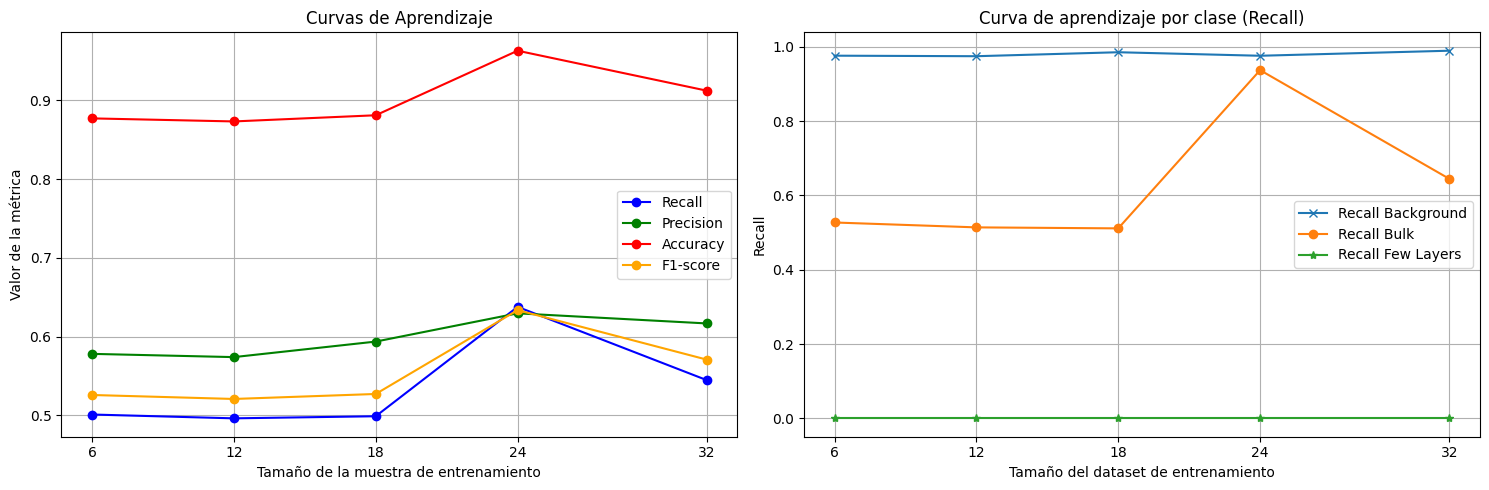

In [ ]:
train_data_size = [6,12,18,24,32]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 2 filas, 1 columna

colors = ['blue', 'green', 'red', 'orange']
metric_names = ['Recall', 'Precision', 'Accuracy', 'F1-score']

for i in range(4):
    x_values = list(average_results.keys())
    y_values = [results[i] for results in average_results.values()]
    axes[0].plot(x_values, y_values, marker='o', color=colors[i], label=metric_names[i])

axes[0].set_xlabel('Tamaño de la muestra de entrenamiento')
axes[0].set_ylabel('Valor de la métrica')
axes[0].set_title('Curvas de Aprendizaje')
axes[0].set_xticks(train_data_size)
axes[0].legend()
axes[0].grid(True)

# Gráfico 2: Curva de Aprendizaje por Clase
train_sizes = sorted(learning_by_data_size.keys())
recall_class1 = [learning_by_data_size[size][0] for size in train_sizes]
recall_class2 = [learning_by_data_size[size][1] for size in train_sizes]
recall_class3 = [learning_by_data_size[size][2] for size in train_sizes]

axes[1].plot(train_sizes, recall_class1, marker='x',label='Recall Background')
axes[1].plot(train_sizes, recall_class2, marker='o',label='Recall Bulk')
axes[1].plot(train_sizes, recall_class3, marker = '*', label='Recall Few Layers')

axes[1].set_xlabel('Tamaño del dataset de entrenamiento')
axes[1].set_ylabel('Recall')
axes[1].set_title('Curva de aprendizaje por clase (Recall)')
axes[1].legend()
axes[1].set_xticks(train_data_size)
axes[1].grid(True)

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()